<a href="https://colab.research.google.com/github/Harry-Kouraklis/Sales-Forecasting-with-AI/blob/main/M5Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Integrate Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"charalamposkouraklis","key":"f53a6f574dd5fbebe17eb4e8026795ca"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 76 May  9 16:37 kaggle.json
{"username":"charalamposkouraklis","key":"f53a6f574dd5fbebe17eb4e8026795ca"}

In [ ]:
!pip install kaggle

In [ ]:
!kaggle competitions download -c m5-forecasting-accuracy

  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 36.9MB/s]
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 58.3MB/s]
 98% 14.0M/14.2M [00:00<00:00, 36.4MB/s]
100% 14.2M/14.2M [00:00<00:00, 47.2MB/s]
 32% 5.00M/15.5M [00:00<00:00, 32.7MB/s]
100% 15.5M/15.5M [00:00<00:00, 61.4MB/s]


#Import Libraries

In [ ]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn import cluster
from matplotlib import cm
plt.style.use('seaborn-whitegrid')
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from fbprophet import Prophet
from tqdm import tqdm, tnrange
from  datetime import datetime, timedelta
import gc
import lightgbm as lgb
from scipy.signal import savgol_filter
from matplotlib.pyplot import figure

In [ ]:
import zipfile
with zipfile.ZipFile("sales_train_validation.csv.zip","r") as zip_ref:
    zip_ref.extractall("")
with zipfile.ZipFile("sample_submission.csv.zip","r") as zip_ref:
    zip_ref.extractall("")
with zipfile.ZipFile("sell_prices.csv.zip","r") as zip_ref:
    zip_ref.extractall("")

In [ ]:
# load training & test datasets
calendar = pd.read_csv("calendar.csv")
sell_prices = pd.read_csv("sell_prices.csv")
sales_train_validation = pd.read_csv("sales_train_validation.csv")
sample_submission=pd.read_csv("sample_submission.csv")
print("Data Shape : ",sell_prices.shape)

Data Shape :  (6841121, 4)


#Memory Usage Reduction

In [ ]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")

In [ ]:
sales_train_validation.info(memory_usage = 'deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 456.8 MB


In [ ]:
reduce_mem_usage(sales_train_validation)

Streaming output truncated to the last 5000 lines.
******************************
******************************
Column:  d_915
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  d_916
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  d_917
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  d_918
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  d_919
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  d_920
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  d_921
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  d_922
dtype before:  int64
dtype after:  uint8
****

In [ ]:
sales_train_validation.info(memory_usage = 'deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: object(6), uint16(271), uint8(1642)
memory usage: 75.3 MB


#Exploratory Data Analysis

**sales_train_validation**: Contains daily information of the amount of product sold each day

In [ ]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [ ]:
sales_train_validation.shape

(30490, 1919)

Searching for missing values.

In [ ]:
sales_train_validation.isnull().sum().sum()

0

Categories for the products can be food, household and hobbies.

In [ ]:
sales_train_validation["store_id"].value_counts()

WI_3    3049
TX_1    3049
CA_3    3049
TX_2    3049
WI_1    3049
CA_1    3049
WI_2    3049
TX_3    3049
CA_2    3049
CA_4    3049
Name: store_id, dtype: int64

All stores appear equal times in the dataframe

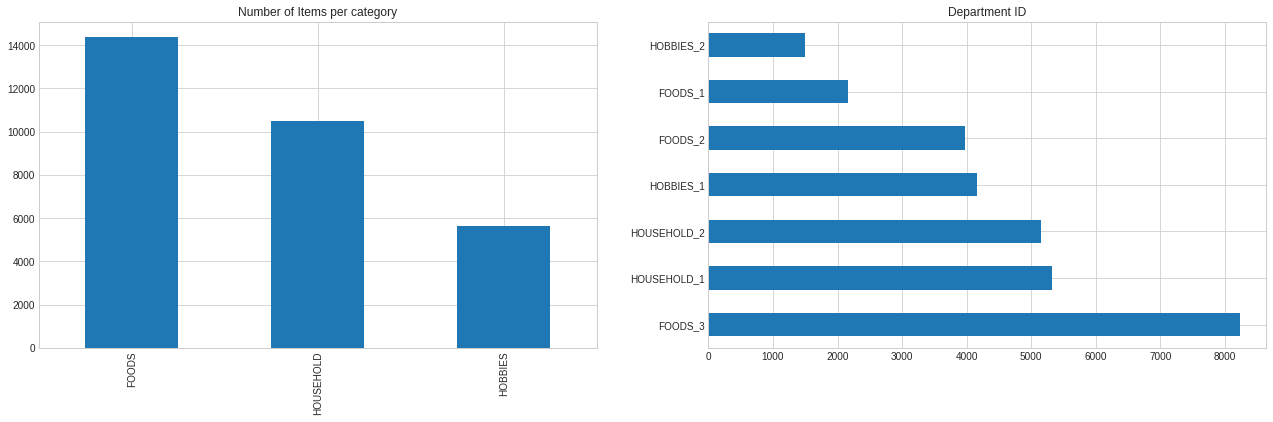

In [ ]:
fig = plt.figure()

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)
# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)

sales_train_validation["cat_id"].value_counts().plot.bar(ax=ax1,figsize=(22,6),title="Number of Items per category")
sales_train_validation["dept_id"].value_counts().plot.barh(ax=ax2,title="Department ID")

In [ ]:
d_cols = [c for c in sales_train_validation.columns if 'd_' in c] # sales data columns

In [ ]:
#Creating new table with only the datetime and the sales
products = sales_train_validation.set_index('id')[d_cols].T.merge(calendar.set_index('d')['date'],
           left_index=True,right_index=True, validate='1:1').set_index('date')

Sales for the three areas denoised with Savitzky-Golay filter

In [ ]:
y=sales_train_validation.groupby('state_id')[d_cols].sum().T
yCA=y.CA
yTX=y.TX
yWI=y.WI

w1 = savgol_filter(yCA, 101, 2)
w2 = savgol_filter(yTX, 101, 2)
w3 = savgol_filter(yWI, 101, 2)

Sales per area. California has the greatest proportion

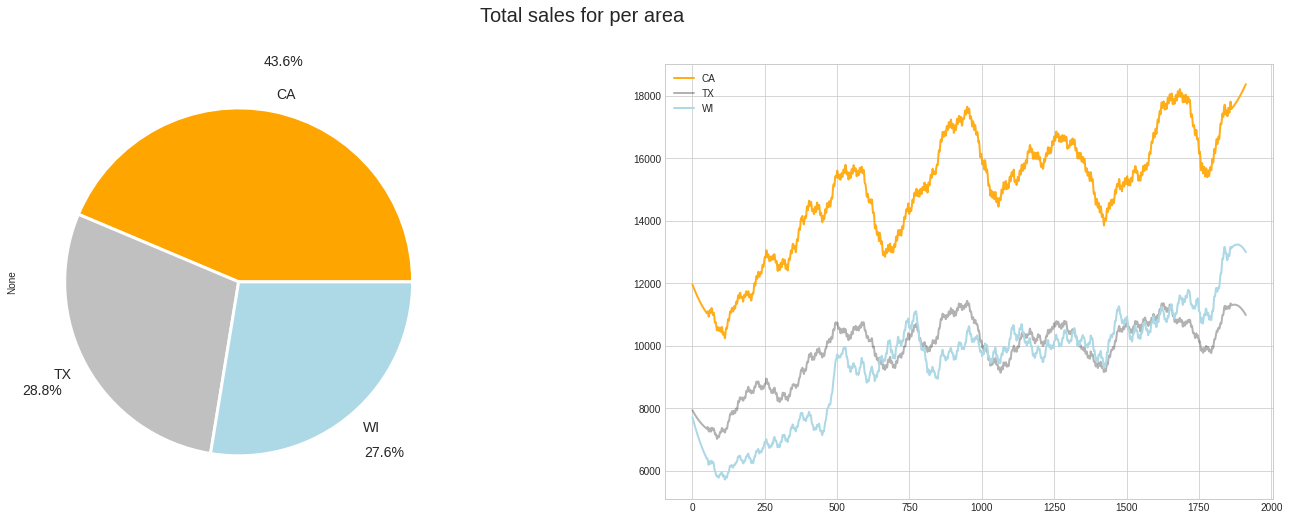

<Figure size 2000x640 with 0 Axes>

In [ ]:
fig = plt.figure()
figure(num=None, figsize=(25, 8), dpi=80)

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)
# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)

sales_train_validation.groupby('state_id')[d_cols].sum().sum(axis=1).plot.pie(ax=ax1,figsize=(24,8),fontsize=14,autopct='%.1f%%', 
                                                                              pctdistance=1.29,colors=['orange','silver','lightblue'],
                                                                              wedgeprops={'linewidth':3, 'edgecolor':'white'})


ax2.plot( w1, 'orange',alpha=0.9,linewidth=2)  # high frequency noise removed
ax2.plot( w2, 'black',alpha=0.3,linewidth=2)  # high frequency noise removed
ax2.plot( w3, 'lightblue',alpha=1,linewidth=2)  # high frequency noise removed
ax2.legend(['CA','TX','WI'])
ax2.xlabel='days'
ax2.ylabel='ylabel'
fig.suptitle('Total sales for per area',fontsize=20)
plt.show()

Total sales per store for the three areas.

Plotting every store total sales with rolling average

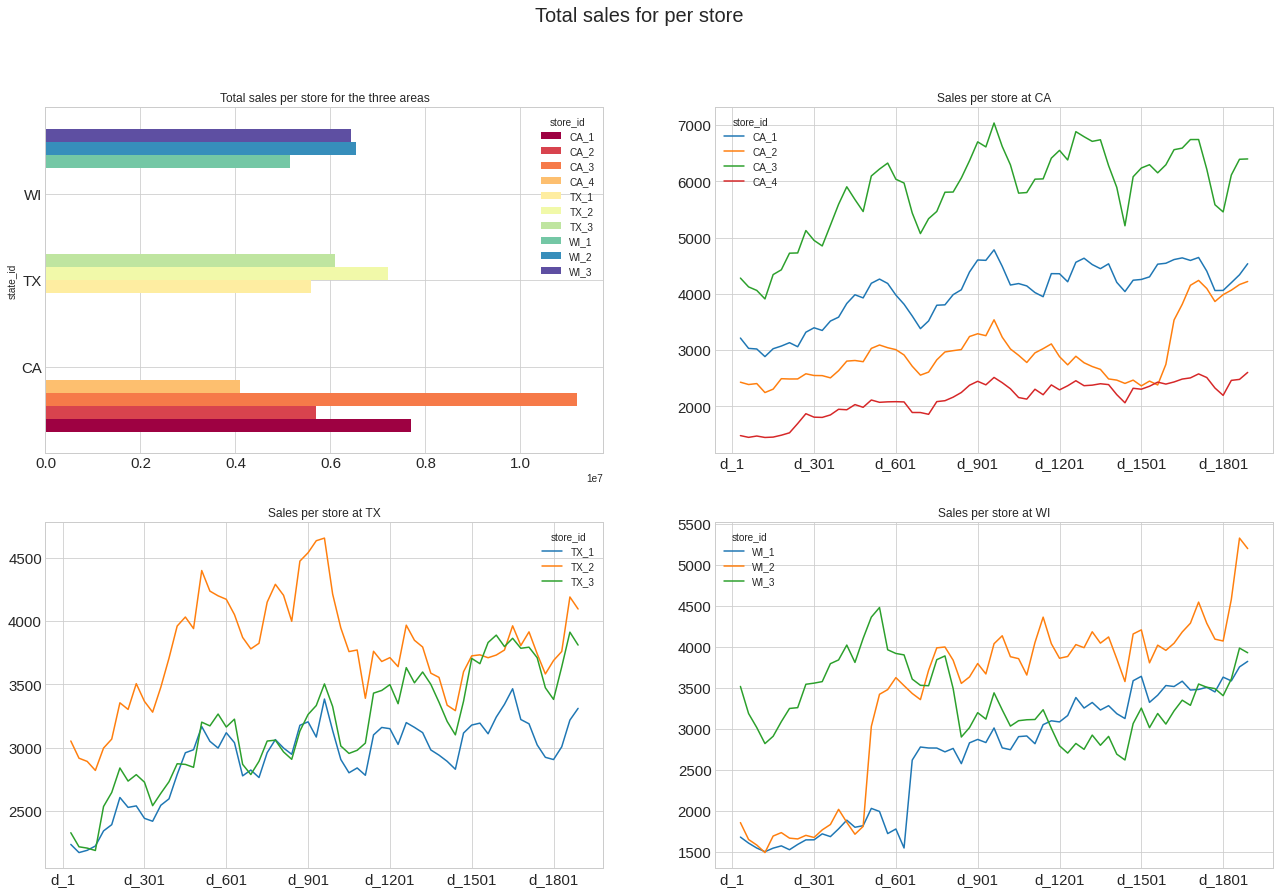

<Figure size 2000x640 with 0 Axes>

In [ ]:
fig = plt.figure()
figure(num=None, figsize=(25, 8), dpi=80)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

cmap='Spectral'
sales_train_validation.groupby(['state_id','store_id'])[d_cols].sum().sum(axis=1).sort_values(ascending=False).\
                                            unstack().plot(ax=ax1,kind='barh',width=1.5,figsize=(22,14),cmap=cmap,
                                                           alpha=1,title='Total sales per store for the three areas',fontsize=15)

y1=sales_train_validation.loc[sales_train_validation.state_id=='CA'].groupby('store_id')[d_cols].sum().T
y1.rolling(30).mean().iloc[::30, :].plot(ax=ax2,title='Sales per store at CA',fontsize=15)

y2=sales_train_validation.loc[sales_train_validation.state_id=='TX'].groupby('store_id')[d_cols].sum().T
y2.rolling(30).mean().iloc[::30, :].plot(ax=ax3,title='Sales per store at TX',fontsize=15)

y3=sales_train_validation.loc[sales_train_validation.state_id=='WI'].groupby('store_id')[d_cols].sum().T
y3.rolling(30).mean().iloc[::30, :].plot(ax=ax4,title='Sales per store at WI',fontsize=15)

fig.suptitle('Total sales for per store',fontsize=20)
plt.show()

All sales over time

Observing an upward trend in total sales

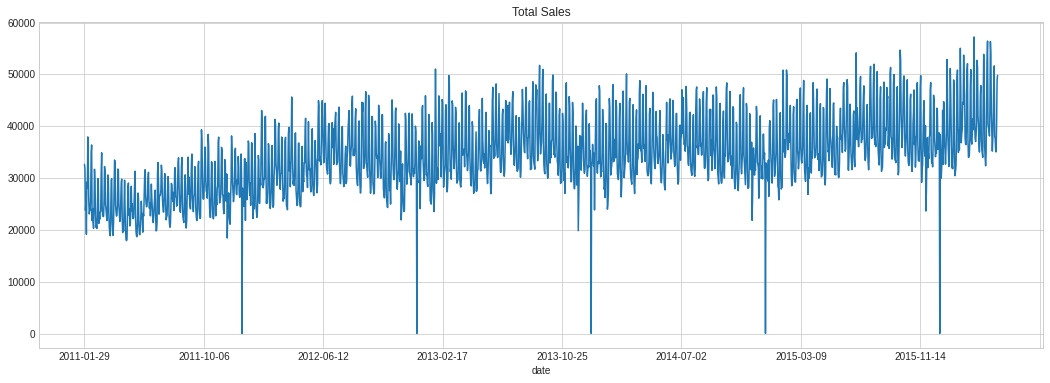

In [ ]:
products.sum(axis=1).plot(figsize=(18, 6), title='Total Sales')

Plotting all sales for 2015

Observing:
 

*   a weekly seasonality 
*   drop to zero sales at Christmas day



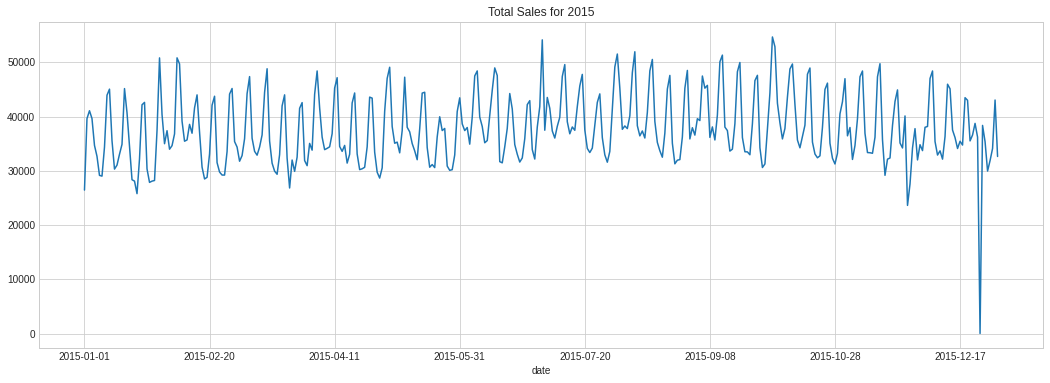

In [ ]:
start='2015-01-01'
end='2016-01-01'
products.loc[start:end,:].sum(axis=1).plot(figsize=(18, 6), title='Total Sales for 2015')

Sales per category over time

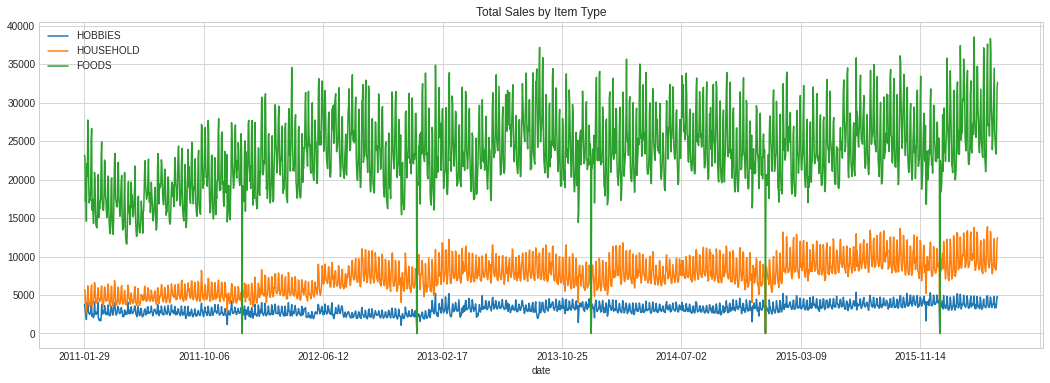

In [ ]:
for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in products.columns if i in c]
    products[items_col].sum(axis=1).plot(figsize=(18, 6), title='Total Sales by Item Type')
plt.legend(sales_train_validation['cat_id'].unique())
plt.show()

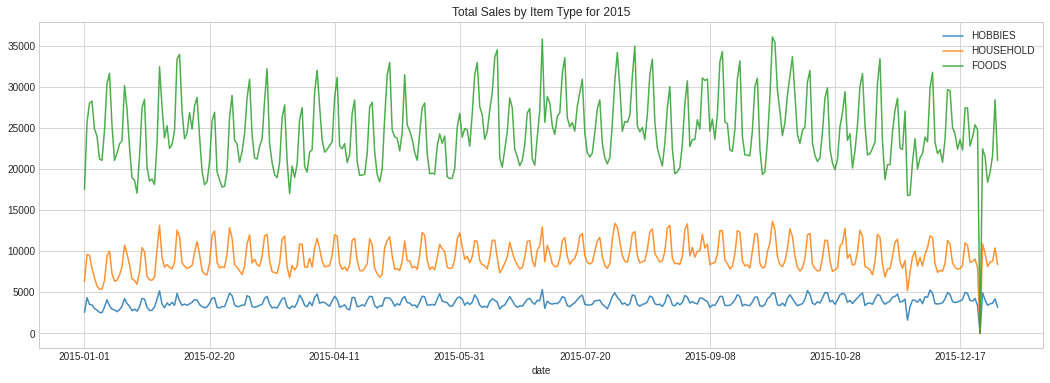

In [ ]:
for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in products.columns if i in c]
    products[items_col].loc[start:end,:].sum(axis=1).plot(figsize=(18, 6),alpha=0.85, title='Total Sales by Item Type for 2015')
plt.legend(sales_train_validation['cat_id'].unique())
plt.show()

Zooming in in December 

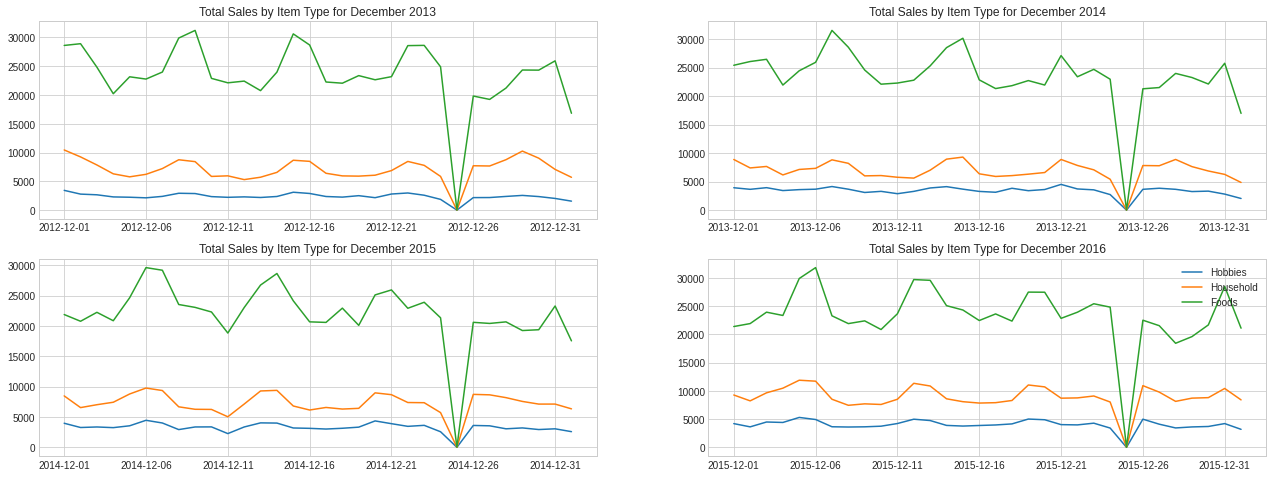

In [ ]:
fig = plt.figure()
# Divide the figure into a 2x2 grid, and give me the first section
ax1 = fig.add_subplot(221)
# Divide the figure into a 2x2 grid, and give me the second section
ax2 = fig.add_subplot(222)
# Divide the figure into a 2x2 grid, and give me the third section
ax3= fig.add_subplot(223)
# Divide the figure into a 2x2 grid, and give me the fourth section
ax4= fig.add_subplot(224)



start='2012-12-01'
end='2013-01-01'
for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in products.columns if i in c]
    products[items_col].loc[start:end,:].sum(axis=1).plot(figsize=(22, 8), title='Total Sales by Item Type for December 2013',ax=ax1)
plt.legend(sales_train_validation['cat_id'].unique())

start='2013-12-01'
end='2014-01-01'
for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in products.columns if i in c]
    products[items_col].loc[start:end,:].sum(axis=1).plot(figsize=(22, 8), title='Total Sales by Item Type for December 2014',ax=ax2)
plt.legend(sales_train_validation['cat_id'].unique())

start='2014-12-01'
end='2015-01-01'
for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in products.columns if i in c]
    products[items_col].loc[start:end,:].sum(axis=1).plot(figsize=(22, 8), title='Total Sales by Item Type for December 2015',ax=ax3)
plt.legend(sales_train_validation['cat_id'].unique())


start='2015-12-01'
end='2016-01-01'
for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in products.columns if i in c]
    products[items_col].loc[start:end,:].sum(axis=1).plot(figsize=(22, 8), title='Total Sales by Item Type for December 2016',ax=ax4)
plt.legend(sales_train_validation['cat_id'].unique())
ax1.set_xlabel(''),ax2.set_xlabel(''),ax3.set_xlabel(''),ax4.set_xlabel('')
plt.legend(["Hobbies","Household","Foods"],loc='upper right')

plt.show()

Find number of products with zero sales per day????????????????????????????????????????????????????????????????????????????????? 

Text(0.5, 0.98, 'Percentage of zero selling products over time')

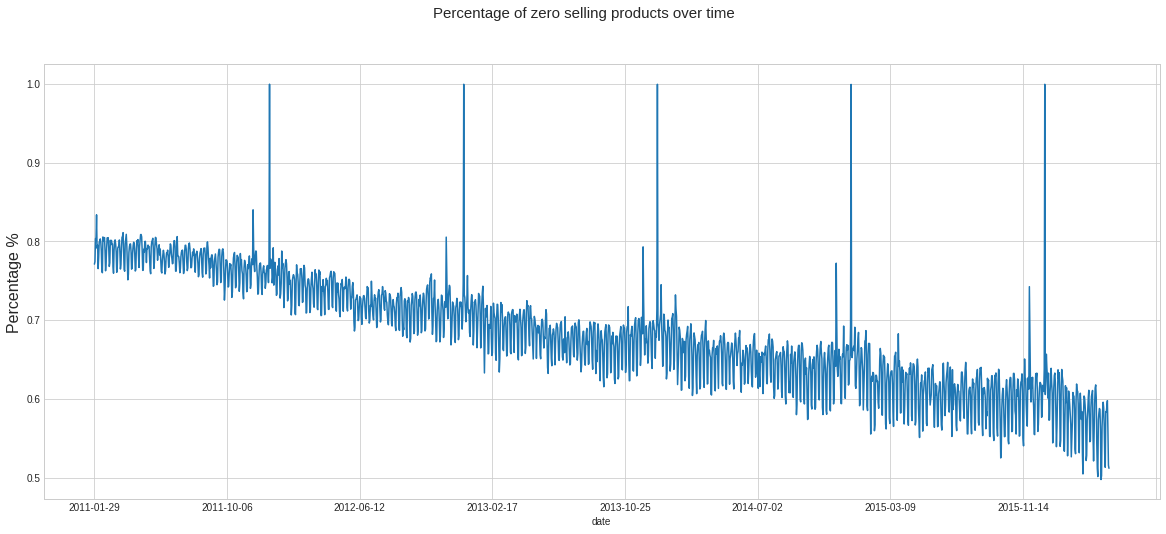

In [ ]:
fig = plt.figure()
products2=(products==0).sum(axis=1)/products.count(axis=1)
products2.plot(figsize=(20,8))
plt.ylabel('Percentage %', fontsize=16)
fig.suptitle('Percentage of zero selling products over time',fontsize=15)

Finding week and month trends

In [ ]:
products2 = sales_train_validation.set_index('id')[d_cols].T.merge(calendar.set_index('d')[['date','weekday','wday']],
           left_index=True,right_index=True, validate='1:1').set_index('weekday')

In [ ]:
products2.head()

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,HOBBIES_1_011_CA_1_validation,HOBBIES_1_012_CA_1_validation,HOBBIES_1_013_CA_1_validation,HOBBIES_1_014_CA_1_validation,HOBBIES_1_015_CA_1_validation,HOBBIES_1_016_CA_1_validation,HOBBIES_1_017_CA_1_validation,HOBBIES_1_018_CA_1_validation,HOBBIES_1_019_CA_1_validation,HOBBIES_1_020_CA_1_validation,HOBBIES_1_021_CA_1_validation,HOBBIES_1_022_CA_1_validation,HOBBIES_1_023_CA_1_validation,HOBBIES_1_024_CA_1_validation,HOBBIES_1_025_CA_1_validation,HOBBIES_1_026_CA_1_validation,HOBBIES_1_027_CA_1_validation,HOBBIES_1_028_CA_1_validation,HOBBIES_1_029_CA_1_validation,HOBBIES_1_030_CA_1_validation,HOBBIES_1_031_CA_1_validation,HOBBIES_1_032_CA_1_validation,HOBBIES_1_033_CA_1_validation,HOBBIES_1_034_CA_1_validation,HOBBIES_1_035_CA_1_validation,HOBBIES_1_036_CA_1_validation,HOBBIES_1_037_CA_1_validation,HOBBIES_1_038_CA_1_validation,HOBBIES_1_039_CA_1_validation,HOBBIES_1_040_CA_1_validation,...,FOODS_3_790_WI_3_validation,FOODS_3_791_WI_3_validation,FOODS_3_792_WI_3_validation,FOODS_3_793_WI_3_validation,FOODS_3_794_WI_3_validation,FOODS_3_795_WI_3_validation,FOODS_3_796_WI_3_validation,FOODS_3_797_WI_3_validation,FOODS_3_798_WI_3_validation,FOODS_3_799_WI_3_validation,FOODS_3_800_WI_3_validation,FOODS_3_801_WI_3_validation,FOODS_3_802_WI_3_validation,FOODS_3_803_WI_3_validation,FOODS_3_804_WI_3_validation,FOODS_3_805_WI_3_validation,FOODS_3_806_WI_3_validation,FOODS_3_807_WI_3_validation,FOODS_3_808_WI_3_validation,FOODS_3_809_WI_3_validation,FOODS_3_810_WI_3_validation,FOODS_3_811_WI_3_validation,FOODS_3_812_WI_3_validation,FOODS_3_813_WI_3_validation,FOODS_3_814_WI_3_validation,FOODS_3_815_WI_3_validation,FOODS_3_816_WI_3_validation,FOODS_3_817_WI_3_validation,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation,date,wday
weekday,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Saturday,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,0,0,0,2,0,0,9,0,0,0,2,0,0,0,0,...,0,0,16,2,1,0,0,0,0,0,36,0,0,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0,2011-01-29,1
Sunday,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,12,6,0,0,0,0,0,0,39,0,0,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0,2011-01-30,2
Monday,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,5,0,0,0,0,0,1,0,0,...,0,0,11,1,1,0,0,0,0,0,34,0,0,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0,2011-01-31,3
Tuesday,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,1,0,0,...,0,0,11,3,1,0,0,0,0,0,42,0,0,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0,2011-02-01,4
Wednesday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,8,0,0,0,0,0,0,0,0,...,0,0,6,5,0,0,0,0,0,0,29,0,0,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0,2011-02-02,5


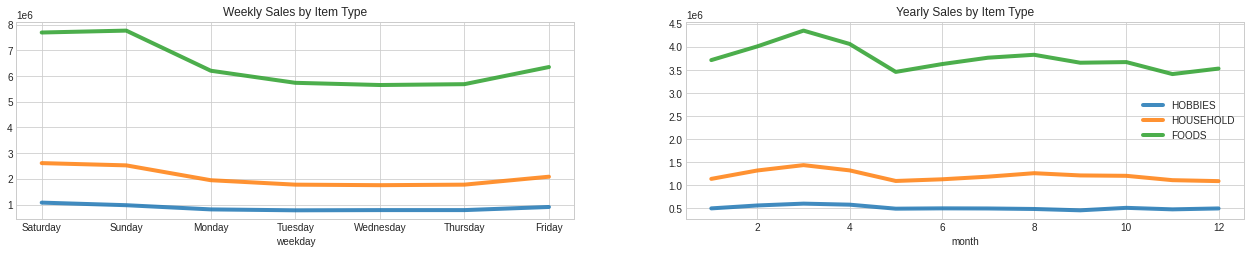

In [ ]:
fig = plt.figure()
# Divide the figure into a 2x2 grid, and give me the first section
ax1 = fig.add_subplot(221)
# Divide the figure into a 2x2 grid, and give me the second section
ax2 = fig.add_subplot(222)
for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in products.columns if i in c]
    products2[items_col].groupby('weekday',sort = False).sum().sum(axis=1).plot(ax=ax1,figsize=(22, 8),alpha=0.85, title='Weekly Sales by Item Type',linewidth=4)
plt.legend(sales_train_validation['cat_id'].unique())

products3 = sales_train_validation.set_index('id')[d_cols].T.merge(calendar.set_index('d')[['date','weekday','month']],
           left_index=True,right_index=True, validate='1:1').set_index('month')
for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in products3.columns if i in c]
    products3[items_col].groupby('month',sort = False).sum().sum(axis=1).plot(ax=ax2,figsize=(22, 8),alpha=0.85, title='Yearly Sales by Item Type',linewidth=4)
plt.legend(sales_train_validation['cat_id'].unique())


plt.show()

In [ ]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


**Events**

34 unique events

In [ ]:
calendar[['event_name_1','event_type_1','event_name_2','event_type_2']].describe()


,event_name_1,event_type_1,event_name_2,event_type_2
count,162,162,5,5
unique,30,4,4,2
top,Mother's day,Religious,Father's day,Cultural
freq,6,55,2,4


Check events for the validation time period

9 different events occur during the validation period.

In [ ]:
calendar[['event_name_1','event_type_1','event_name_2','event_type_2']].loc[1914:,].describe()

,event_name_1,event_type_1,event_name_2,event_type_2
count,8,8,1,1
unique,8,4,1,1
top,Mother's day,Religious,Father's day,Cultural
freq,1,3,1,1


Price changes of prducts

In [ ]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
sell_prices.shape

(6841121, 4)

In [ ]:
sell_prices.groupby(['store_id','item_id'])['sell_price'].count()

store_id  item_id        
CA_1      FOODS_1_001        282
          FOODS_1_002        282
          FOODS_1_003        282
          FOODS_1_004        225
          FOODS_1_005        282
                            ... 
WI_3      HOUSEHOLD_2_512    282
          HOUSEHOLD_2_513    168
          HOUSEHOLD_2_514    282
          HOUSEHOLD_2_515    127
          HOUSEHOLD_2_516    282
Name: sell_price, Length: 30490, dtype: int64

#Models

We will train our models for the validation period of day 1900 to day 1914

In order to evaluate our models we will predict the prices of the:

*   4 most demanded items
*   4 random items
*   4 least popular items





Most and least popular products

In [ ]:
sales_train_validation[d_cols].sum(axis=1).sort_values(ascending=False)

8412     250502
18055    192835
21104    150122
8908     134386
2314     127203
          ...  
26276        16
20192        16
27606        13
6048         12
6682         10
Length: 30490, dtype: int64

In [ ]:
print(sales_train_validation.iloc[100,:][d_cols].sum())
print(sales_train_validation.iloc[200,:][d_cols].sum())
print(sales_train_validation.iloc[300,:][d_cols].sum())
print(sales_train_validation.iloc[400,:][d_cols].sum())

1604
334
1308
1809


In [ ]:
popular_items_columns=[8412,18055,21104,8908]

least_popular_items_columns=[26276,20192,27606,6048]

random_items_columns=[100,200,300,400]

No Events that occur during that period:

In [ ]:
calendar[['event_name_1','event_type_1','event_name_2','event_type_2']].loc['d_1886':'d_1913',:].describe()

,event_name_1,event_type_1,event_name_2,event_type_2
count,0,0,0,0
unique,0,0,0,0
top,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN


One-hot encoding Calendar

In [ ]:
from sklearn.preprocessing import LabelEncoder

nonservingcols = ["wm_yr_wk", "wday",'weekday','month','year']
dates = calendar.drop(nonservingcols, axis = 1)
dates=dates.rename({"date": "ds"},axis=1)
dates["Date"] = dates.index


In [ ]:
dates = dates.fillna(0)

categorical_cols = ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
my_labeler = LabelEncoder()
for i in categorical_cols:
    dates[i] = my_labeler.fit_transform(dates[i].astype("str"))

In [ ]:
dates=dates.drop(['d','Date'],axis=1)

In [ ]:
holidays=dates.iloc[1913-22-1091:1913-22,:]

In [ ]:
holidays=holidays.reset_index(drop=True)

##Prophet

In [ ]:
from multiprocessing import Pool, cpu_count

In [ ]:
def run_prophet(timeserie):
    model = Prophet(uncertainty_samples=False,holidays=holidays,n_changepoints = 50, 
                    changepoint_range = 0.9, changepoint_prior_scale = 0.9) # changepoint_prior_scale default is 0.5. Increasing it 
                                                                            # will make the trend more flexible
    model.fit(timeserie)
    future = model.make_future_dataframe(periods=28, include_history=False)
    forecast = model.predict(future)
    return forecast

print(f'Parallelism on {cpu_count()} CPU')

Parallelism on 2 CPU


In [ ]:
start_from= 800
for i in popular_items_columns+least_popular_items_columns+random_items_columns:
    temp_series = sales_train_validation.iloc[i,start_from:-28]
    temp_series.index = calendar['date'][start_from:start_from+len(temp_series)]
    temp_series =  pd.DataFrame(temp_series)
    temp_series = temp_series.reset_index()
    temp_series.columns = ['ds', 'y']

    with Pool(cpu_count()) as p:
        forecast1 = p.map(run_prophet, [temp_series])

    sample_submission.iloc[i,1:]=forecast1[0]['yhat'].values

sample_submission.iloc[:,1:]=sample_submission.iloc[:,1:].where(sample_submission.iloc[:,1:] > 0).fillna(0)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

**Popular items**

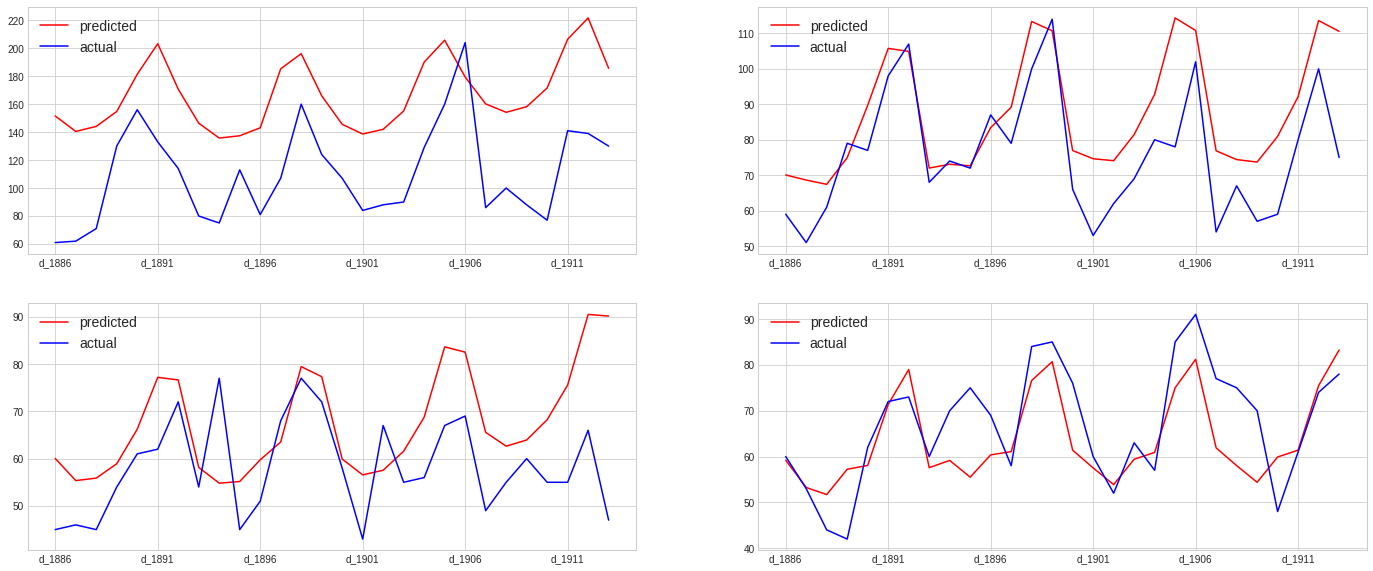

<Figure size 432x288 with 0 Axes>

<Figure size 1600x640 with 0 Axes>

In [ ]:
fig = plt.figure()
# Divide the figure into a 2x2 grid, and give me the first section
ax1 = fig.add_subplot(221)
# Divide the figure into a 2x2 grid, and give me the second section
ax2 = fig.add_subplot(222)
# Divide the figure into a 2x2 grid, and give me the third section
ax3= fig.add_subplot(223)
# Divide the figure into a 2x2 grid, and give me the fourth section
ax4= fig.add_subplot(224)

fig = plt.figure()
figure(num=None, figsize=(20, 8), dpi=80)


sample_submission.iloc[8412,1:].plot(color='red',label='predicted',ax=ax1,figsize=(24, 10))
sales_train_validation.iloc[8412,-28:].plot(color='blue',label='actual',ax=ax1)
ax1.legend(['predicted','actual'],fontsize=14)

sample_submission.iloc[18055,1:].plot(color='red',label='predicted',ax=ax2,figsize=(24, 10))
sales_train_validation.iloc[18055,-28:].plot(color='blue',label='actual',ax=ax2)
ax2.legend(['predicted','actual'],fontsize=14)

sample_submission.iloc[21104,1:].plot(color='red',label='predicted',ax=ax3,figsize=(24, 10))
sales_train_validation.iloc[21104,-28:].plot(color='blue',label='actual',ax=ax3)
ax3.legend(['predicted','actual'],fontsize=14)

sample_submission.iloc[8908,1:].plot(color='red',label='predicted',ax=ax4,figsize=(24, 10))
sales_train_validation.iloc[8908,-28:].plot(color='blue',label='actual',ax=ax4)
ax4.legend(['predicted','actual'],fontsize=14)


fig.suptitle('Predictions',fontsize=20)
plt.show()

**Least popular items**

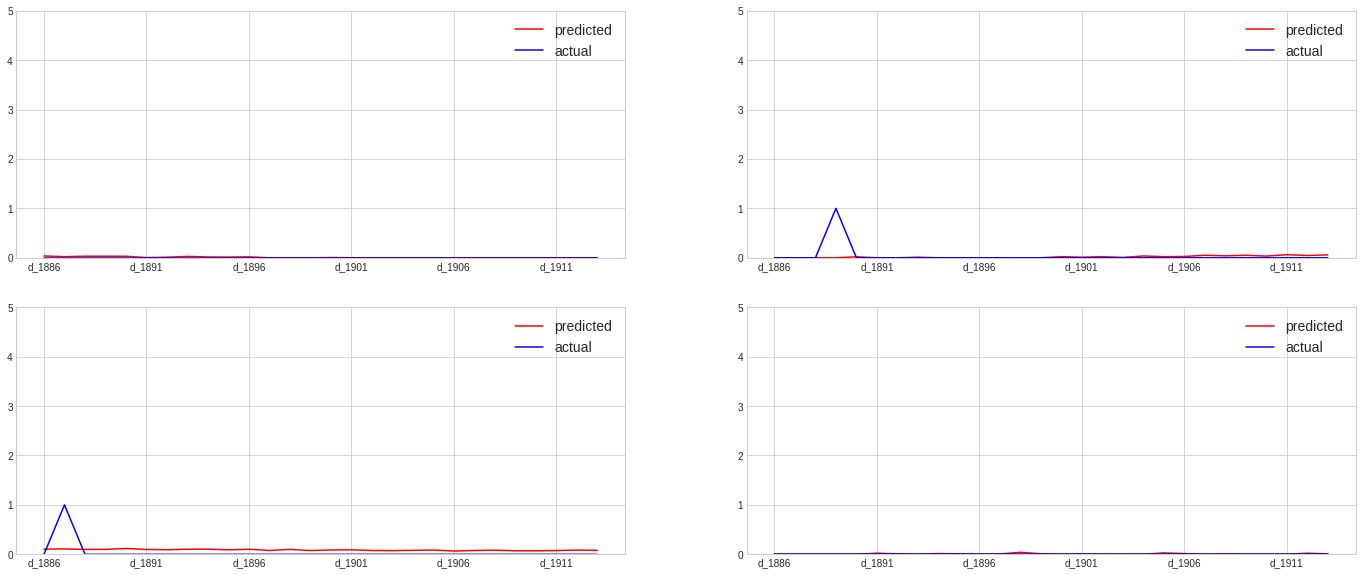

<Figure size 432x288 with 0 Axes>

<Figure size 1600x640 with 0 Axes>

In [ ]:
fig = plt.figure()
# Divide the figure into a 2x2 grid, and give me the first section
ax1 = fig.add_subplot(221)
# Divide the figure into a 2x2 grid, and give me the second section
ax2 = fig.add_subplot(222)
# Divide the figure into a 2x2 grid, and give me the third section
ax3= fig.add_subplot(223)
# Divide the figure into a 2x2 grid, and give me the fourth section
ax4= fig.add_subplot(224)

fig = plt.figure()
figure(num=None, figsize=(20, 8), dpi=80)


sample_submission.iloc[26276,1:].plot(color='red',label='predicted',ax=ax1,figsize=(24, 10))
sales_train_validation.iloc[26276,-28:].plot(color='blue',label='actual',ax=ax1)
ax1.legend(['predicted','actual'],fontsize=14)
ax1.set_ylim(0,5)

sample_submission.iloc[20192,1:].plot(color='red',label='predicted',ax=ax2,figsize=(24, 10))
sales_train_validation.iloc[20192,-28:].plot(color='blue',label='actual',ax=ax2)
ax2.legend(['predicted','actual'],fontsize=14)
ax2.set_ylim(0,5)

sample_submission.iloc[27606,1:].plot(color='red',label='predicted',ax=ax3,figsize=(24, 10))
sales_train_validation.iloc[27606,-28:].plot(color='blue',label='actual',ax=ax3)
ax3.legend(['predicted','actual'],fontsize=14)
ax3.set_ylim(0,5)

sample_submission.iloc[6048,1:].plot(color='red',label='predicted',ax=ax4,figsize=(24, 10))
sales_train_validation.iloc[6048,-28:].plot(color='blue',label='actual',ax=ax4)
ax4.legend(['predicted','actual'],fontsize=14)
ax4.set_ylim(0,5)


fig.suptitle('Predictions',fontsize=20)
plt.show()

**Random items**

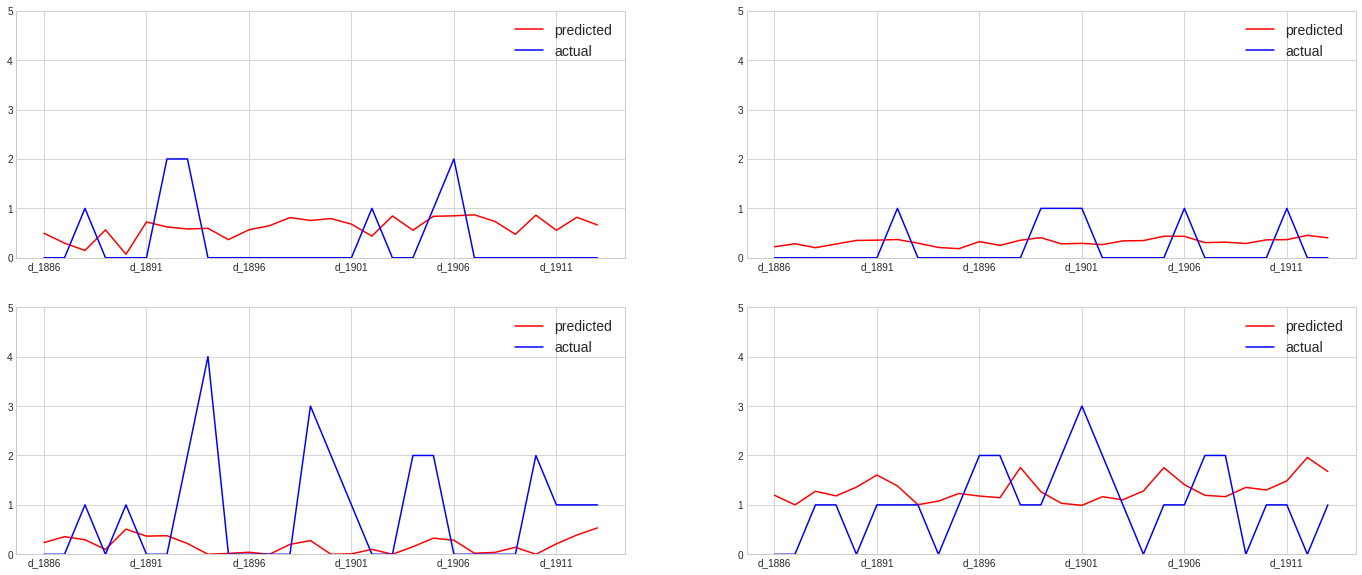

<Figure size 432x288 with 0 Axes>

<Figure size 1600x640 with 0 Axes>

In [ ]:
fig = plt.figure()
# Divide the figure into a 2x2 grid, and give me the first section
ax1 = fig.add_subplot(221)
# Divide the figure into a 2x2 grid, and give me the second section
ax2 = fig.add_subplot(222)
# Divide the figure into a 2x2 grid, and give me the third section
ax3= fig.add_subplot(223)
# Divide the figure into a 2x2 grid, and give me the fourth section
ax4= fig.add_subplot(224)

fig = plt.figure()
figure(num=None, figsize=(20, 8), dpi=80)


sample_submission.iloc[100,1:].plot(color='red',label='predicted',ax=ax1,figsize=(24, 10))
sales_train_validation.iloc[100,-28:].plot(color='blue',label='actual',ax=ax1)
ax1.legend(['predicted','actual'],fontsize=14)
ax1.set_ylim(0,5)

sample_submission.iloc[200,1:].plot(color='red',label='predicted',ax=ax2,figsize=(24, 10))
sales_train_validation.iloc[200,-28:].plot(color='blue',label='actual',ax=ax2)
ax2.legend(['predicted','actual'],fontsize=14)
ax2.set_ylim(0,5)

sample_submission.iloc[300,1:].plot(color='red',label='predicted',ax=ax3,figsize=(24, 10))
sales_train_validation.iloc[300,-28:].plot(color='blue',label='actual',ax=ax3)
ax3.legend(['predicted','actual'],fontsize=14)
ax3.set_ylim(0,5)

sample_submission.iloc[400,1:].plot(color='red',label='predicted',ax=ax4,figsize=(24, 10))
sales_train_validation.iloc[400,-28:].plot(color='blue',label='actual',ax=ax4)
ax4.legend(['predicted','actual'],fontsize=14)
ax4.set_ylim(0,5)


fig.suptitle('Predictions',fontsize=20)
plt.show()

##For the whole dataset

In [ ]:
start_from_ob = 800
for i in tnrange(sales_train_validation.shape[0]):
    temp_series = sales_train_validation.iloc[i,start_from_ob:]
    temp_series.index = calendar['date'][start_from_ob:start_from_ob+len(temp_series)]
    temp_series =  pd.DataFrame(temp_series)
    temp_series = temp_series.reset_index()
    temp_series.columns = ['ds', 'y']

    with Pool(cpu_count()) as p:
        forecast1 = p.map(run_prophet, [temp_series])

    sample_submission.iloc[i,1:] = forecast1[0]['yhat'].values

sample_submission.iloc[:,1:]=sample_submission.iloc[:,1:].where(sample_submission.iloc[:,1:] > 0).fillna(0)

In [ ]:
sample_submission

In [ ]:
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "Charalampos Kouraklis Submission"

In [ ]:
columns = sales_train_validation.columns
date_columns = columns[columns.str.contains("d_")]
dates_s = [pd.to_datetime(calendar.loc[calendar['d'] == str_date,'date'].values[0]) for str_date in date_columns]

In [ ]:
tmp = sales_train_validation[date_columns].sum()
ignore_date = calendar[calendar['d'].isin(tmp[tmp < 10000].index.values)]['date'].values

df_ev_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': calendar[~calendar['event_name_1'].isna()]['date']})
df_ev_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': calendar[~calendar['event_name_2'].isna()]['date']})
df_ev_3 = pd.DataFrame({'holiday': 'snap_CA', 'ds': calendar[calendar['snap_CA'] == 1]['date']})
df_ev_4 = pd.DataFrame({'holiday': 'snap_TX', 'ds': calendar[calendar['snap_TX'] == 1]['date']})
df_ev_5 = pd.DataFrame({'holiday': 'snap_WI', 'ds': calendar[calendar['snap_WI'] == 1]['date']})
holidays = pd.concat((df_ev_1, df_ev_2, df_ev_3, df_ev_4, df_ev_5))